In [1]:
import numpy as np
import sys
sys.path.append('..')
sys.path.append('../..')
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from forestflow.model_p3d_arinyo import ArinyoModel
from forestflow.archive import GadgetArchive3D
from lace.cosmo import camb_cosmo
import forestflow
import mask_calculations as mc
import os
import contamination

In [2]:
import matplotlib as mpl


In [3]:
# # plot soem random skewers
# skews = np.load("/data/desi/common/HydroData/Emulator/post_768/delta_x/central_with_silicon_spike/skewers_6_psim_plus_ax1_Ns768_wM0.05_sT1.0_sg1.0.npz")
# delta_flux = skews['delta_flux_x']
# xpar = skews['xpar']

In [4]:
# kpar = np.fft.fftfreq(len(xpar), skews['los_spacing_Mpc'])
# deltak = np.fft.fft(delta_flux[4])
# plt.plot(kpar, deltak)
# plt.xlim([-1,1])
# plt.ylim([-200,200])

In [5]:
# del delta_flux

In [6]:
def retrieve_masked_p1d(mask_path, maskname, snapnum):
    p1ds_masked = []
    c=0
    for phase in ['plus','minus']:
        for ax in range(1,4):
            
            fname = mask_path+f"skewers_{snapnum}_psim_{phase}_ax{ax}{maskname}_mask_p1d.npz"
            if os.path.exists(fname):
                print(fname)
                f = np.load(fname)
                p1ds_masked.append(f['p1d_masked_dimless'])
                if c==0:
                    kpar = f['kpar']
                    L    = f['L_Mpc']
                    Np   = f['Np']
                c+=1
    p1ds_masked = np.asarray(p1ds_masked)
    p1ds_masked_avg = np.average(p1ds_masked, axis=0) # *L/Np**2
    return kpar, L, Np, p1ds_masked_avg

Load the data

In [7]:
# set sim_name
sim_name='sim_pair_30' # other version will be 'diffSeed'
sim_dir='central'
snap_num = 6
pix_spacing = 0.05

In [8]:
path_program = os.path.dirname(forestflow.__path__[0]) + '/'
folder_lya_data = path_program + "/data/best_arinyo/"
Archive3D = GadgetArchive3D(
    base_folder=path_program[:-1],
    folder_data=folder_lya_data,
    force_recompute_plin=False,
    average="both",
)

In [9]:
# load the unmasked p1d measurement
sim = Archive3D.get_testing_data('mpg_central', force_recompute_plin=False)
sim_z = [d for d in sim if d["z"] == 3][0]

In [10]:
mask_path = "/data/desi/scratch/mlokken/masking_silicon_spike/"

In [11]:
p1d_archived = sim_z['p1d_Mpc']
kpar, L, Np, p1d_unmasked = retrieve_masked_p1d(mask_path, 'non', 6)
p1d_unmasked = p1d_unmasked*L/Np**2 # I am going to pre-normalize this because it will serve as my 'model', not a measurement
kpar_archived = sim_z['k_Mpc']

/data/desi/scratch/mlokken/masking_silicon_spike/skewers_6_psim_plus_ax1non_mask_p1d.npz
/data/desi/scratch/mlokken/masking_silicon_spike/skewers_6_psim_plus_ax2non_mask_p1d.npz
/data/desi/scratch/mlokken/masking_silicon_spike/skewers_6_psim_plus_ax3non_mask_p1d.npz
/data/desi/scratch/mlokken/masking_silicon_spike/skewers_6_psim_minus_ax1non_mask_p1d.npz
/data/desi/scratch/mlokken/masking_silicon_spike/skewers_6_psim_minus_ax2non_mask_p1d.npz
/data/desi/scratch/mlokken/masking_silicon_spike/skewers_6_psim_minus_ax3non_mask_p1d.npz


In [12]:
# get the Arinyo model for this
cosmo = camb_cosmo.get_cosmology_from_dictionary(sim[0]["cosmo_params"])
camb_results = camb_cosmo.get_camb_results(cosmo, zs=[sim_z['z']], camb_kmax_Mpc=1000) # set default cosmo
arinyo = ArinyoModel(cosmo=cosmo, camb_results=camb_results, zs=[sim_z['z']], camb_kmax_Mpc=1000) # set model
arinyo_bestfit = sim_z['Arinyo_min'] # best-fitting Arinyo params
bestfit_model_p1d = arinyo.P1D_Mpc(k_par=kpar_archived, z=sim_z['z'], parameters=arinyo_bestfit)

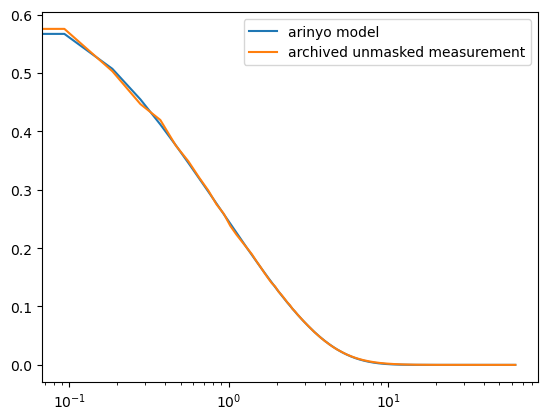

In [13]:
plt.plot(kpar_archived, bestfit_model_p1d, label='arinyo model')
plt.plot(kpar_archived, p1d_archived, label='archived unmasked measurement')
plt.xscale('log')
plt.legend()

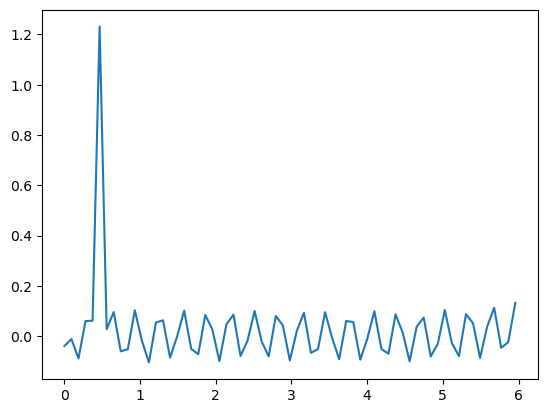

In [14]:
plt.plot(kpar_archived[0:65], (p1d_unmasked[0:65]-bestfit_model_p1d[0:65])/bestfit_model_p1d[0:65])


(0.0, 4.0)

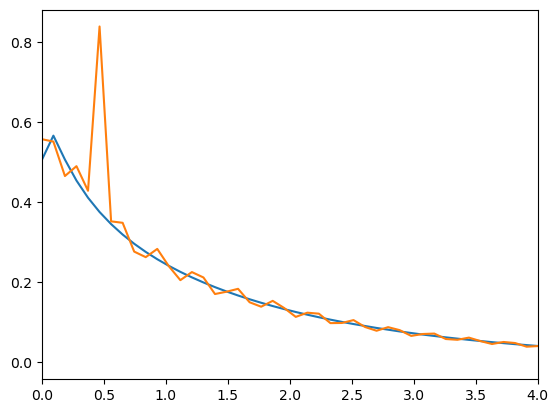

In [15]:
# get the model
plt.plot(kpar_archived, bestfit_model_p1d)
Sil = contamination.SiliconModel()
Spike = contamination.SpikeModel(a_spike=0.5)

contaminated_p1d = bestfit_model_p1d * Sil.power_contamination(kpar_archived)+ Spike.power_contamination(kpar_archived)
plt.plot(kpar_archived, contaminated_p1d)
plt.xlim([0,4])

In [31]:
# load the masked P1D measurements

# mode = 'all'
# mode = 'none'
# mode = 'dla_small'
# mode = '2skyline'
mode = 'skyline'
# mode = 'dla_large'
# mode = 'random'

In [32]:
# read the masks
maskdir = "/data/desi/scratch/mlokken/masking/"
masks = []
masknames = []

masklist = ['random_mask.npy', 'skyline_mask.npy', 'double_skyline_mask.npy', 'dla_mask.npy', 'dla_small_mask.npy']
if mode=='random':
    index = 0
elif mode=='skyline':
    index = 1
elif mode=='2skyline':
    index = 2
elif mode=='dla_large':
    index = 3
elif mode=='dla_small':
    index = 4
        
if mode=='all':
    for maskfile in masklist:
        masks.append(np.load(maskdir+maskfile))
        # ((nside, nside, Np)) reshape
        masknames.append(os.path.splitext(maskfile)[0])
        break # only load first for sake of memory
else:
    maskfile = masklist[index]
    masks.append(np.load(maskdir+maskfile))
    masknames.append(os.path.splitext(maskfile)[0])
    mask = masks[0]

In [33]:

if mode=='all':
    kpar, L, Np, p1d_2skyline = retrieve_masked_p1d(mask_path, 'double_skyline', 6)
    kpar, L, Np, p1d_dla_large = retrieve_masked_p1d(mask_path, 'dla', 6)
    kpar, L, Np, p1d_randmasked = retrieve_masked_p1d(mask_path, 'random', 6)
    kpar, L, Np, p1d_skyline = retrieve_masked_p1d(mask_path, 'skyline', 6)
    kpar, L, Np, p1d_dla_small = retrieve_masked_p1d(mask_path, 'dla_small', 6)
    kpar, L, Np, p1d_unmasked = retrieve_masked_p1d(mask_path, 'non', 6)
if mode == 'none':
    kpar, L, Np, p1d_nonmask = retrieve_masked_p1d(mask_path, 'non', 6)
if mode=='2skyline':
    kpar, L, Np, p1d_masked = retrieve_masked_p1d(mask_path, 'double_skyline', 6)
    label = 'double line'
    title = 'Double Line'
elif mode=='skyline':
    kpar, L, Np, p1d_masked = retrieve_masked_p1d(mask_path, 'skyline', 6)
    label = 'single line'
    title = 'Single Line'
elif mode=='random':
    kpar, L, Np, p1d_masked = retrieve_masked_p1d(mask_path, 'random', 6)
    label = 'random'
    title = 'Random'
elif mode=='dla_large':
    kpar, L, Np, p1d_masked = retrieve_masked_p1d(mask_path, 'dla', 6)
    label = 'large DLA'
    title = 'Large DLA'
elif mode=='dla_small':
    kpar, L, Np, p1d_masked = retrieve_masked_p1d(mask_path, 'dla_small', 6)
    label = 'small DLA'
    title = 'Small DLA'

/data/desi/scratch/mlokken/masking_silicon_spike/skewers_6_psim_plus_ax1skyline_mask_p1d.npz
/data/desi/scratch/mlokken/masking_silicon_spike/skewers_6_psim_plus_ax2skyline_mask_p1d.npz
/data/desi/scratch/mlokken/masking_silicon_spike/skewers_6_psim_plus_ax3skyline_mask_p1d.npz
/data/desi/scratch/mlokken/masking_silicon_spike/skewers_6_psim_minus_ax1skyline_mask_p1d.npz
/data/desi/scratch/mlokken/masking_silicon_spike/skewers_6_psim_minus_ax2skyline_mask_p1d.npz
/data/desi/scratch/mlokken/masking_silicon_spike/skewers_6_psim_minus_ax3skyline_mask_p1d.npz


In [34]:
mpl.rcParams.update({'font.size': 12})
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12) 

In [35]:
if mode=='all':

    mask_correction = [(np.average(np.sum(mask, axis=1))/mask[0].size) for mask in masks]
    nmodes = 300
    kpar_cut = kpar[:nmodes]
    # wkcut = wk[:nmodes]
    wkcut = np.ones(nmodes)
    #set of 5 colors
    colors=['blue', 'orange', '#B07C9E', 'green', 'red', 'blue']
    two_panel = False
    if two_panel:
        # make a three-panel figure with the lower panels smaller
        fig, ax = plt.subplots(2, 1, figsize=[8, 8], gridspec_kw={'height_ratios': [1, 1]}, sharex=True)
    
        ax[0].plot(kpar_cut, p1d_unmasked[:nmodes]/wkcut, 's', label='no masking', color=colors[5], alpha=.3)
        ax[0].plot(kpar_cut, p1d_randmasked[:nmodes]/wkcut, label=f'random masking', color=colors[1], alpha=.3)
        ax[0].plot(kpar_cut, p1d_skyline[:nmodes]/wkcut,  label=f'skyline masking', color=colors[2], alpha=.3)
        ax[0].plot(kpar_cut, p1d_2skyline[:nmodes]/wkcut,  label=f'double skyline masking', color=colors[3], alpha=.3)
        ax[0].plot(kpar_cut, p1d_dla_large[:nmodes]/wkcut, '^', label=f'DLA masking', color=colors[4], alpha=.3)
        ax[0].set_xlim([0,6])
        ax[0].legend()
        ax[0].set_ylabel(r'$P_{1D}$ [Mpc]')    
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=[7, 4])
        ax = [0,ax1]
    # plt.suptitle(r"Measured $P_\mathrm{1D}$ (hydro sim) after masking")
    
    
    
    # plot the pct difference from no-masking in the lower panel
    ax[1].axhspan(-1, 1, color='grey', alpha=0.3)
    ax[1].axhline([0], color='gray')
    
    ax[1].plot(kpar_cut, ((p1d_skyline[:nmodes]/mask_correction)/p1d_unmasked[:nmodes]-1)*100, linestyle='solid', color=colors[2], label='single line', lw=2)
    ax[1].plot(kpar_cut, ((p1d_2skyline[:nmodes]/mask_correction)/p1d_unmasked[:nmodes]-1)*100, linestyle='dashdot', color=colors[3], label='double line', lw=2)
    ax[1].plot(kpar_cut, ((p1d_dla_small[:nmodes]/mask_correction)/p1d_unmasked[:nmodes]-1)*100, linestyle='dashed', color=colors[5], label='small DLA', lw=2)
    ax[1].plot(kpar_cut, ((p1d_dla_large[:nmodes]/mask_correction)/p1d_unmasked[:nmodes]-1)*100, linestyle='dotted', color=colors[4], label='large DLA', lw=2)
    ax[1].plot(kpar_cut, ((p1d_randmasked[:nmodes]/mask_correction)/p1d_unmasked[:nmodes]-1)*100, linestyle='solid', color=colors[1], label='random', lw=2)
    ax[1].legend(loc='upper left', ncol=1)
    
    ax[1].set_ylim([-3, 10])
    ax[1].set_xscale('log')
    ax[1].set_xlim([.08,10])
    ax[1].set_ylabel(r'$100  \left(\dfrac{\mathrm{masked}~~P_\mathrm{1D}}{\mathrm{orig.}~~P_\mathrm{1D}}-1 \right)$')
    ax[1].set_xlabel(r"$k_{\parallel}$ [Mpc$^{-1}$]")
    plt.savefig("../plots/p1d_hydro_five_masks_pctdiff_silicon_spike.pdf", bbox_inches="tight")

In [36]:
if mode == 'none':
    nmodes = 300
    kpar_cut = kpar[:nmodes]
    # wkcut = wk[:nmodes]
    wkcut = np.ones(nmodes)
    #set of 5 colors
    colors=['blue', 'orange', 'brown', 'green', 'red', 'blue']
    
    fig, ax = plt.subplots(2, 1, figsize=[8, 8], gridspec_kw={'height_ratios': [1, 1]}, sharex=True)    
    ax[0].plot(kpar_cut, p1d_unmasked[:nmodes]/wkcut,  label='no masking, pre contamination', color=colors[0])
    ax[0].plot(kpar_cut, p1d_nonmask[:nmodes]/wkcut, label='no masking', color=colors[1])
    ax[0].plot(kpar_archived, contaminated_p1d, label='model', linestyle='dashed')
    ax[0].legend()
    ax[1].plot(kpar_cut, ((p1d_nonmask[:nmodes])/p1d_unmasked[:nmodes]-1)*100, linestyle='dashdot', color=colors[3], label='double skyline masking')
    ax[1].set_xscale('log')
    plt.legend()

In [37]:
kmax = np.pi/pix_spacing
kbin_spacing = kpar[1]-kpar[0]

# make a set of bins with kpar as centers
kbin_est = np.array([[kp-(kpar[1]-kpar[0])/2, kp+(kpar[1]-kpar[0])/2] for kp in kpar])
Nbin = len(kbin_est)

Get the FFT measurements

In [38]:
def model_mask_slow(nmodes, mask, p1d, lowmem=True):
    masked_p1d_est = np.zeros(nmodes)
    for m in range(nmodes):
        if m%10==0:
            print("Getting model for mode", m)
        if lowmem:
            masked_p1d_est[m] = mc.calculate_masked_power_fft_loop(m, mask, p1d)
        else:
            masked_p1d_est[m] = mc.calculate_masked_power_fft_array(m, mask, p1d)
    return masked_p1d_est

def plot_mask_model(nmodes, kpar, unmasked_model, masked_measurement, masked_model, title,  L=L, Np=Np, renorm=True, Anorm=None):
    if renorm:
        masked_measurement *= Anorm
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=[7,6], gridspec_kw={'height_ratios': [3, 1.5]})
    kpar_cut = kpar[:nmodes]
    ax[0].plot(kpar_cut, unmasked_model[:nmodes], label='Orig. model', linestyle='solid', color='orange')
    ax[0].plot(kpar_cut, masked_model, label='Masked model', linestyle='dashed', color='blue')
    
    ax[0].scatter(kpar_cut, masked_measurement[:nmodes], label='Meas. after\n masking', color='green')
    ax[0].set_ylim([0,.9])
    ax[0].legend(loc='upper right')
    ax[0].set_xscale('log')
    ax[1].set_xlabel(r'$k$ [Mpc$^{-1}$]')
    ax[0].set_ylabel(r'$P_\mathrm{1D}$ [Mpc]')
    ax[0].set_xlim([.1,5])
    ax[0].set_title(title)
    ax[1].plot(kpar_cut, (masked_measurement[:nmodes]/unmasked_model[:nmodes]-1)*100, label='Model = orig.', color='orange')
    ax[1].plot(kpar_cut, (masked_measurement[:nmodes]/masked_model[:nmodes]-1)*100, label='Model = masked', color='blue', linestyle='dashed')
    # ax[1].legend(loc=[.02, .8], framealpha=1)
    ax[1].set_ylabel(r"$100\left(\dfrac{\mathrm{Meas.}}{\mathrm{Model}}-1\right)$")
    ax[1].axhspan(-1, 1, color='grey', alpha=0.3)
    ax[1].set_ylim([-2.5,2.5])
    plt.savefig(f"../plots/p1d_hydro_{mode}_mask_model.pdf", bbox_inches='tight')
    plt.show()
    plt.clf()
def plot_mask_model_pctdiff(nmodes, kpar, unmasked_model, masked_measurement, masked_model, title, L=L, Np=Np, renorm=True, Anorm=None):
    if renorm:
        masked_measurement *= Anorm
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[7,2])
    kpar_cut = kpar[:nmodes]
    ax.axhspan(-1, 1, color='grey', alpha=0.3)
    ax.plot(kpar_cut, ((masked_measurement[:nmodes])/unmasked_model[:nmodes]-1)*100, label='Model=orig.', color='orange')
    ax.plot(kpar_cut, (masked_measurement[:nmodes]/masked_model[:nmodes]-1)*100, label='Model=masked', color='blue', linestyle='dashed')
    
    if mode=='random':
        ax.legend(loc=[.01, .63], framealpha=.7, fontsize=14)
    if mode=='dla_small' or mode=='dla_large': # right two
        ax.set_yticklabels([])
    if mode=='random' or mode=='skyline': # left two
        ax.set_ylabel(r"$100\times\left(\dfrac{\mathrm{Meas.}}{\mathrm{Model}}-1\right)$")
    if mode=='dla_large' or mode=='random': # upper two
        ax.set_xticklabels([])
    if mode=='dla_small' or mode=='skyline': # bottom two
        ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
    plt.title(title)
    ax.set_xscale('log')
    
    ax.set_ylim([-2.5,2.5])
    ax.set_xlim([.1,5])
    plt.savefig(f"../plots/p1d_hydro_{mode}_mask_model_pctdiff.pdf", bbox_inches='tight')
    plt.show()
    plt.clf()



In [39]:
# same for bestfit
bestfit_model_p1d_full = np.concatenate((bestfit_model_p1d, bestfit_model_p1d[1:-1][::-1]))
contaminated_model_p1d_full = np.concatenate((contaminated_p1d, contaminated_p1d[1:-1][::-1]))

In [40]:
del masks

In [41]:
# avg_mask_squared = np.sum((mask.real**2 + mask.imag**2), axis=0)/mask.shape[0]
# plt.plot(kpar[:36], avg_mask_squared[:36])
# plt.title(f"Average {label} mask in Fourier space")

In [42]:
# # Get the normalizations for the estimator

# if mode=='all':
#     # skyline_mask_k = np.fft.fft(masks[1], axis=1)
#     # skyline_2mask_k = np.fft.fft(masks[2], axis=1)
#     # dla_mask_k = np.fft.fft(masks[3], axis=1)
#     # random_mask_k = np.fft.fft(masks[0], axis=1)
#     # mask_correction = [(np.average(np.sum(mask, axis=1))/mask[0].size) for mask in masks]
#     pass
# else:
#     estnorm = mc.calculate_norms(resolution, mask, L)
    
#     # calculate the P1D normalization factor for the power by what fraction of signal, on average, the mask removes in delta-x space
#     # mask_correction = (np.average(np.sum(masks[0], axis=1))/masks[0][0].size)
#     # W = mc.calculate_W(masks[0])
#     # mask = np.fft.fft(masks[0], axis=1)

In [43]:
resolution = np.ones(mask.shape[1]) # perfect resolution for sims
if mode=='all':
    model_2skyline = model_mask(nmodes, skyline_2mask_k, p1d_unmasked_full)
    model_dla = model_mask(nmodes, dla_mask_k, p1d_unmasked_full)
    model_rand = model_mask(nmodes, random_mask_k, p1d_unmasked_full)
    model_skyline = model_mask(nmodes, skyline_mask_k, p1d_unmasked_full)
    
else:
    # model_with_cosvar = mc.calculate_masked_power(avg_mask_squared/Np**2, contaminated_model_p1d_full)
    # model_no_cosvar = mc.calculate_masked_power(avg_mask_squared/Np**2, p1d_unmasked)
    window_matrix, estnorm, W = mc.calculate_window_matrix(mask, resolution, L)
    model_with_cosvar = mc.masked_theory(window_matrix, contaminated_model_p1d_full)
    model_no_cosvar   = mc.masked_theory(window_matrix, p1d_unmasked)

In [44]:
mpl.rcParams.update({'font.size': 14})
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14) 

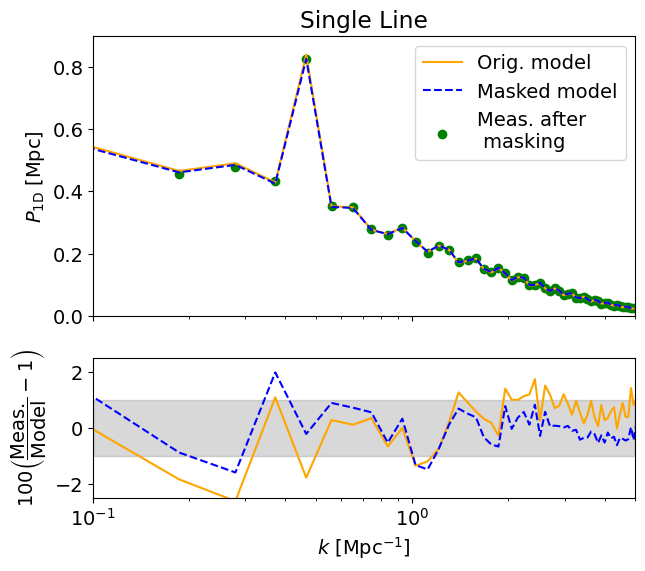

<Figure size 640x480 with 0 Axes>

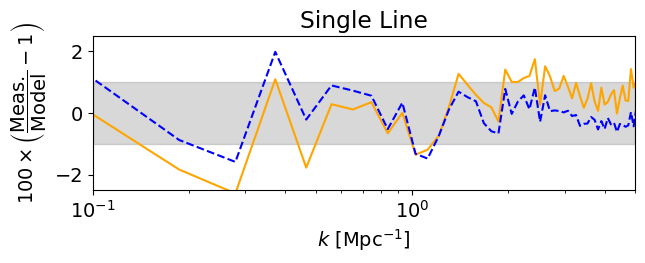

<Figure size 640x480 with 0 Axes>

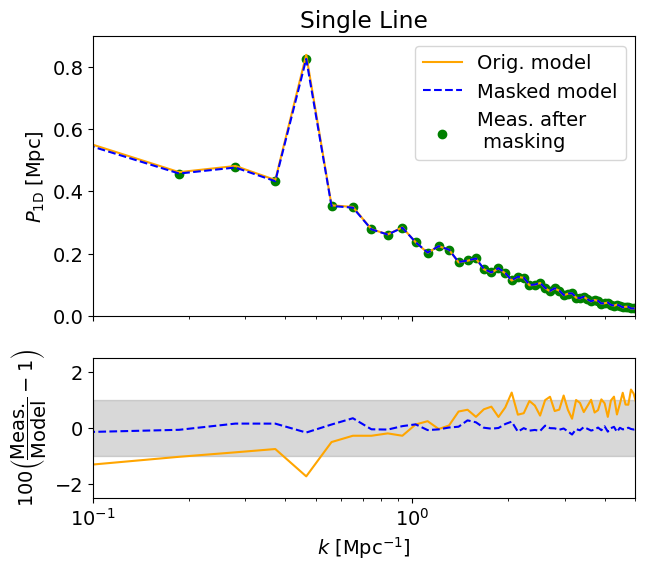

<Figure size 640x480 with 0 Axes>

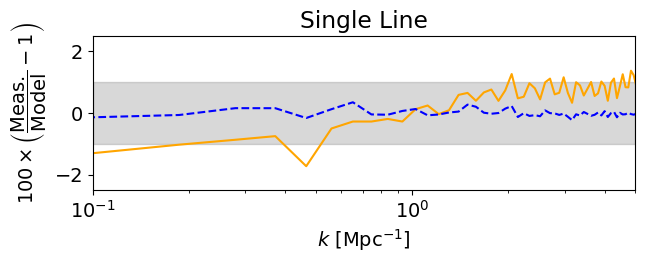

<Figure size 640x480 with 0 Axes>

In [45]:
nmodes = 60
if mode=='all':
    plot_mask_model(nmodes, kpar, p1d_unmasked, p1d_randmasked, model_rand, 'random', L=L, Np=Np)
    plot_mask_model(nmodes, kpar, p1d_unmasked, p1d_skyline, model_skyline, 'skyline', L=L, Np=Np)
    plot_mask_model(nmodes, kpar, p1d_unmasked, p1d_dla, model_dla, 'DLA', L=L, Np=Np)
    plot_mask_model(nmodes, kpar, p1d_unmasked, p1d_2skyline, model_2skyline, 'double skyline', L=L, Np=Np)
else:
    plot_mask_model(nmodes, kpar, np.copy(contaminated_model_p1d_full), np.copy(p1d_masked), np.copy(model_with_cosvar.real[:nmodes]), title, L=L, Np=Np, Anorm = estnorm)
    plot_mask_model_pctdiff(nmodes, kpar, np.copy(contaminated_model_p1d_full), np.copy(p1d_masked), np.copy(model_with_cosvar.real[:nmodes]), title, L=L, Np=Np, Anorm=estnorm)
    plot_mask_model(nmodes, kpar, np.copy(p1d_unmasked), np.copy(p1d_masked), np.copy(model_no_cosvar.real[:nmodes]), title, L=L, Np=Np,  Anorm=estnorm)
    plot_mask_model_pctdiff(nmodes, kpar, np.copy(p1d_unmasked), np.copy(p1d_masked), np.copy(model_no_cosvar[:nmodes]), title, L=L, Np=Np, Anorm=estnorm)